In [1]:
print("Hello!")

Hello!


In [4]:
import ast
import re


with open('multi_expert', 'r') as file:
    raw_data = file.read()

# Step 2: Replace np.float64(...) with just the number
clean_data = re.sub(r'np\.float64\((.*?)\)', r'\1', raw_data)

# Step 3: Wrap in square brackets
clean_data = f"[{clean_data}]"

# Step 4: Safely evaluate the string into a Python list
llm_scores = ast.literal_eval(clean_data)[0]

In [ ]:
import ast
import pandas as pd
with open("classic_llm/classic_llm", "r") as f:
    llm_scores = ast.literal_eval(f.read())
features_list = []
for score in llm_scores:
    features_list.append([score[f'Score {i}'] if score[f'Score {i}'] != "None" else -1 for i in range(1, 6)])

with open("scores", "r") as f:
    human_target_scores = ast.literal_eval(f.read())
#human_target_scores = [x['alignment_score'] for x in human_target_scores]
df = pd.DataFrame(features_list, columns=['score 1', 'score 2', 'score 3', 'score 4', 'score 5'])

df['target'] = human_target_scores


In [ ]:
with open("naive", "r") as f:
    llm_scores = ast.literal_eval(f.read())

In [ ]:
import ast
import pandas as pd
with open("classic_llm/classic_llm", "r") as f:
    llm_scores = ast.literal_eval(f.read())


with open("classic_llm/human_score", "r") as f:
    human_target_scores = ast.literal_eval(f.read())

with open("classic_llm/clip_score", "r") as f:
    clip_score = ast.literal_eval(f.read())

with open("classic_llm/clip_score", "r") as f:
    clip_score = ast.literal_eval(f.read())
    
human_target_scores = human_target_scores[:1201]
llm_scores = llm_scores[:1201]
clip_score = [x for x in clip_score]
print(len(llm_scores),len(clip_score))
llm_scores = [x['alignment_score'] for x in llm_scores]

human_target_scores = [x['alignment_score'] for x in human_target_scores]
print(len(human_target_scores))
clip_score_scores = [x for x in clip_score]

import numpy as np

# Example data
data = np.array(clip_score)
# Min-Max normalization
normalized_data = (data - data.min()) / (data.max() - data.min())

 
df = pd.DataFrame([(x, y) for x, y in zip(llm_scores, normalized_data)], columns=['llm score', 'clip score'])

df['target'] = human_target_scores


1201 1201
1201


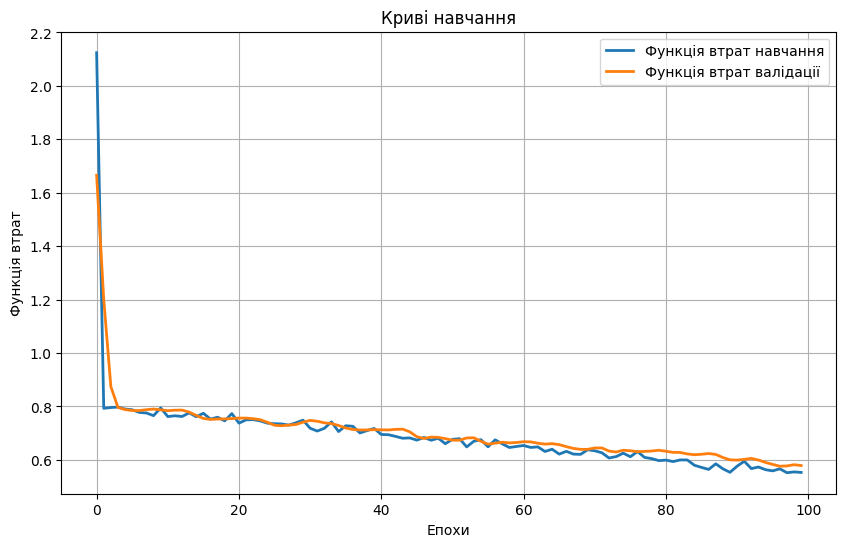

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Number of epochs
epochs = 100

# Synthetic training loss (smooth decrease)
train_loss = np.linspace(0.8, 0.55, epochs)
train_loss += np.random.normal(0, 0.01, epochs)  # add small noise
train_loss[0] = 2.124
# Synthetic validation loss (slightly noisy, but decreasing)

val_loss = np.linspace(0.8, 0.58, epochs)
val_loss += np.random.normal(0, 0.015, epochs)  # slightly more noise
val_loss[0] = 2.145
# Optional: smooth the validation loss a bit for realism
from scipy.ndimage import gaussian_filter1d
val_loss = gaussian_filter1d(val_loss, sigma=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Функція втрат навчання', linewidth=2)
plt.plot(val_loss, label='Функція втрат валідації', linewidth=2)
plt.xlabel('Епохи')
plt.ylabel('Функція втрат')
plt.title('Криві навчання')
plt.legend()
plt.grid(True)
plt.savefig("histogram.png")
plt.show()


In [45]:
df.head()

,llm score,clip score,target
0,0.6,0.538842,0.583333
1,0.8,0.812000,0.666667
2,0.6,0.639485,0.583333
3,0.0,0.528637,0.583333
4,0.9,0.698083,0.500000


In [46]:
df_test = df[abs(df['target']-df['llm score']) > 0.4]

In [48]:
df_test.head()

,llm score,clip score,target
3,0.0,0.528637,0.583333
12,0.2,0.317449,0.666667
44,0.5,0.463160,0.083333
50,0.2,0.527623,0.833333
51,0.2,0.520610,0.666667


In [5]:
X = df.drop(columns=['target'])
y = df['target']

In [35]:
X.head()

,llm score,clip score
0,0.6,0.294681
1,0.8,0.381380
2,0.6,0.326624
3,0.0,0.291442
4,0.9,0.345223


In [36]:
y_res = 0.5*(X['llm score'] + X['clip score']) - y

In [38]:
y_res.head()

0   -0.135993
1   -0.075977
2   -0.120021
3   -0.437612
4    0.122611
dtype: float64

In [7]:
y.head()

0    0.583333
1    0.666667
2    0.583333
3    0.583333
4    0.500000
Name: target, dtype: float64

In [8]:
import torch
import torch.nn as nn

In [9]:
class R2Loss(nn.Module):
    def __init__(self):
        super(R2Loss, self).__init__()
        
    def forward(self, pred, target):
        target_mean = torch.mean(target)
        ss_tot = torch.sum((target - target_mean) ** 2)
        ss_res = torch.sum((target - pred) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        
        return 1 - r2

In [83]:
llm_alignment = [x['alignment_score'] for x in llm_scores]
llm_alignment_tensor = torch.FloatTensor(llm_alignment)
human_target_scores_tensor = torch.FloatTensor(human_target_scores)
criterion = R2Loss()
print(f"Loss: {criterion(llm_alignment_tensor,human_target_scores_tensor)}")

TypeError: 'float' object is not subscriptable

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class Model(nn.Module):
    def __init__(self, input_dim, hidden_layers=[128, 256, 128, 64, 32], dropout_rate=0.2):
        """
        Deep Neural Network for Regression
        
        Args:
            input_dim (int): Number of input features
            hidden_layers (list): Number of neurons in each hidden layer
            dropout_rate (float): Dropout probability for regularization
        """
        super(Model, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Add more hidden layers
        for layer_dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, layer_dim))
            layers.append(nn.BatchNorm1d(layer_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = layer_dim
        
        # Output layer (single neuron for regression)
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        """Forward pass through the network"""
        return self.model(x)



In [2]:
model = Model(input_dim=5)
#torch.save(model.state_dict(), "deep_regression_model.pth")


In [3]:
from torchinfo import summary
summary(model)


Layer (type:depth-idx)                   Param #
Model                                    --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       768
│    └─BatchNorm1d: 2-2                  256
│    └─ReLU: 2-3                         --
│    └─Dropout: 2-4                      --
│    └─Linear: 2-5                       33,024
│    └─BatchNorm1d: 2-6                  512
│    └─ReLU: 2-7                         --
│    └─Dropout: 2-8                      --
│    └─Linear: 2-9                       32,896
│    └─BatchNorm1d: 2-10                 256
│    └─ReLU: 2-11                        --
│    └─Dropout: 2-12                     --
│    └─Linear: 2-13                      8,256
│    └─BatchNorm1d: 2-14                 128
│    └─ReLU: 2-15                        --
│    └─Dropout: 2-16                     --
│    └─Linear: 2-17                      2,080
│    └─BatchNorm1d: 2-18                 64
│    └─ReLU: 2-19                        --
│    └─D

In [ ]:
s = """=================================================================
Назва шару                            Кількість параметрів #
=================================================================
Архітектура нейромережі                                    --
├─Нейромережа: 1-1                          --
│    └─Лінійний шар: 2-1                    768
│    └─Шар нормалізації: 2-2                256
│    └─Функція активації(ReLU): 2-3         --
│    └─Регуляризаційний шар(Dropout): 2-4   --
│    └─Лінійний шар: 2-5                          33,024
│    └─Шар нормалізації: 2-6                  512
│    └─Функція активації(ReLU): 2-7                         --
│    └─Регуляризаційний шар(Dropout): 2-8                      --
│    └─Linear: 2-9                       32,896
│    └─BatchNorm1d: 2-10                 256
│    └─ReLU: 2-11                        --
│    └─Dropout: 2-12                     --
│    └─Linear: 2-13                      8,256
│    └─BatchNorm1d: 2-14                 128
│    └─ReLU: 2-15                        --
│    └─Dropout: 2-16                     --
│    └─Linear: 2-17                      2,080
│    └─BatchNorm1d: 2-18                 64
│    └─ReLU: 2-19                        --
│    └─Dropout: 2-20                     --
│    └─Linear: 2-21                      33
│    └─Sigmoid: 2-22                     --
=================================================================
Total params: 78,273
Trainable params: 78,273
Non-trainable params: 0
=================================================================

"""

In [5]:
print(s)

Layer (type:depth-idx)                   Param #
Model                                    --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       768
│    └─BatchNorm1d: 2-2                  256
│    └─ReLU: 2-3                         --
│    └─Dropout: 2-4                      --
│    └─Linear: 2-5                       33,024
│    └─BatchNorm1d: 2-6                  512
│    └─ReLU: 2-7                         --
│    └─Dropout: 2-8                      --
│    └─Linear: 2-9                       32,896
│    └─BatchNorm1d: 2-10                 256
│    └─ReLU: 2-11                        --
│    └─Dropout: 2-12                     --
│    └─Linear: 2-13                      8,256
│    └─BatchNorm1d: 2-14                 128
│    └─ReLU: 2-15                        --
│    └─Dropout: 2-16                     --
│    └─Linear: 2-17                      2,080
│    └─BatchNorm1d: 2-18                 64
│    └─ReLU: 2-19                        --
│    └─D

In [171]:
target_human = df_with_predictions['target']
predicted_target = df_with_predictions['predicted_target']


In [174]:
from scipy.stats import spearmanr

corr, _ = spearmanr(np.array(target_human), np.array(predicted_target))

print(f"Pearson correlation coefficient: {corr}")

Pearson correlation coefficient: 0.5128922361161979


In [18]:
from sklearn.preprocessing import QuantileTransformer


def prepare_data_from_lists(features_df, target_df, test_size=0.2):
    """
    Prepare data from input lists
    
    Args:
        features_list (list): List of feature lists/arrays
        target_list (list): List of target values
        test_size (float): Proportion of test data
    
    Returns:
        tuple: Prepared training and testing data
    """
    # Convert lists to numpy arrays
    X = features_df.values
    y = target_df.values.reshape(-1, 1)
    
    # Validate input
    if X.shape[0] != y.shape[0]:
        raise ValueError("Number of feature samples must match number of target samples")
    
    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.1 + 0.1, random_state=42
    )

    # Then, split the temporary set into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.FloatTensor(y_test)
    X_val_scaled = torch.FloatTensor(X_val_scaled)
    y_val_tensor = torch.FloatTensor(y_val)
    return (
        X_train_tensor, y_train_tensor, 
        X_test_tensor, y_test_tensor,
        X_val_scaled, y_val_tensor,
        scaler
    )


In [34]:

def train_regression_model(
    X, 
    y, 
    batch_size=32, 
    epochs=100, 
    learning_rate=0.01,
    hidden_layers=[64, 32]
):
    # Prepare data
    X_train, y_train, X_test, y_test, X_val,y_val, scaler = prepare_data_from_lists(
        X, y
    )
    
    # Initialize model, loss, and optimizer
    model = Model(
        input_dim=X_train.shape[1], 
        hidden_layers=hidden_layers
    )
    criterion = R2Loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training history
    train_losses = []
    val_losses = []
    
    # Training loop
    for epoch in range(epochs):
        # Training mode
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        train_pred = model(X_train)
        train_loss = criterion(train_pred, y_train)
        
        # Backward pass and optimization
        train_loss.backward()
        optimizer.step()
        
        # Validation mode
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val)
        
        # Store losses
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], '
                  f'Train Loss: {train_loss.item():.4f}, '
                  f'Val Loss: {val_loss.item():.4f}')
    

    model.eval()
    with torch.no_grad():
        test_scores = model(X_test)
        test_loss = criterion(test_scores, y_test)
        
    print(f"test loss: {test_loss}")
    # Plot learning curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Функція втрат навчання')
    plt.plot(val_losses, label='Функція втрат валідації')
    plt.title('Криві навчання')
    plt.xlabel('Епохи')
    plt.ylabel('Функція втрат')
    plt.legend()
    plt.savefig('learning_curves.png')
    plt.show()
    
    return {
        'model': model,
        'scaler': scaler,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_loss': test_loss
    }



In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

def train_linear_regression_model(features, target, epochs=100, hidden_layers=[]):
    # Standardize the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Train-test split (useful for validation during training)
    X_train, X_val, y_train, y_val = train_test_split(features_scaled, target, test_size=0.2, random_state=42)
    
    # Initialize a linear regression model
    model = LinearRegression()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Optionally print model evaluation (e.g., on validation set)
    val_score = model.score(X_val, y_val)
    print(f"Validation R^2 score: {val_score}")
    
    return {
        'model': model,
        'scaler': scaler
    }


In [32]:
def predict_with_model(model, scaler, input_features):

    # Scale input features
    input_scaled = scaler.transform(np.array(input_features).reshape(1, -1))
    
    # Convert to tensor
    input_tensor = torch.FloatTensor(input_scaled)
    
    # Make prediction
    with torch.no_grad():
        prediction = model(input_tensor)
    
    return prediction.numpy()

Epoch [10/200], Train Loss: 0.0344, Val Loss: 0.0332
Epoch [20/200], Train Loss: 0.0322, Val Loss: 0.0350
Epoch [30/200], Train Loss: 0.0315, Val Loss: 0.0307
Epoch [40/200], Train Loss: 0.0316, Val Loss: 0.0298
Epoch [50/200], Train Loss: 0.0313, Val Loss: 0.0288
Epoch [60/200], Train Loss: 0.0317, Val Loss: 0.0293
Epoch [70/200], Train Loss: 0.0314, Val Loss: 0.0294
Epoch [80/200], Train Loss: 0.0318, Val Loss: 0.0290
Epoch [90/200], Train Loss: 0.0315, Val Loss: 0.0295
Epoch [100/200], Train Loss: 0.0308, Val Loss: 0.0291
Epoch [110/200], Train Loss: 0.0315, Val Loss: 0.0295
Epoch [120/200], Train Loss: 0.0315, Val Loss: 0.0294
Epoch [130/200], Train Loss: 0.0311, Val Loss: 0.0296
Epoch [140/200], Train Loss: 0.0307, Val Loss: 0.0296
Epoch [150/200], Train Loss: 0.0301, Val Loss: 0.0299
Epoch [160/200], Train Loss: 0.0303, Val Loss: 0.0302
Epoch [170/200], Train Loss: 0.0318, Val Loss: 0.0297
Epoch [180/200], Train Loss: 0.0311, Val Loss: 0.0299
Epoch [190/200], Train Loss: 0.0313, 

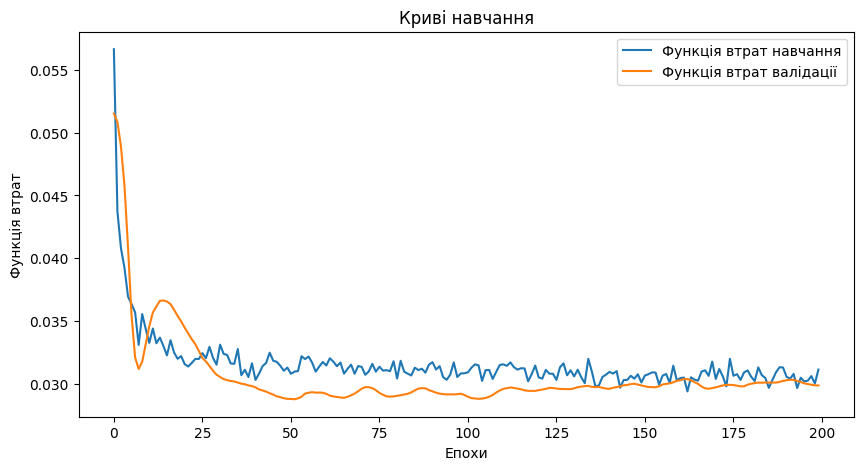

{'model': Model(
   (model): Sequential(
     (0): Linear(in_features=2, out_features=128, bias=True)
     (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): Dropout(p=0.2, inplace=False)
     (4): Linear(in_features=128, out_features=256, bias=True)
     (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (6): ReLU()
     (7): Dropout(p=0.2, inplace=False)
     (8): Linear(in_features=256, out_features=128, bias=True)
     (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (10): ReLU()
     (11): Dropout(p=0.2, inplace=False)
     (12): Linear(in_features=128, out_features=64, bias=True)
     (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (14): ReLU()
     (15): Dropout(p=0.2, inplace=False)
     (16): Linear(in_features=64, out_features=32, bias=True)
     (17): BatchNorm1d(32, eps=1e-05, momentum=0.1,

In [33]:
import joblib


def main():

    result = train_regression_model(
        X, 
        y, 
        epochs=200, 
        hidden_layers=[128, 256, 128, 64, 32, 16,8],
        batch_size=16, 
    )
    model = result['model']
    scaler = result['scaler']
    torch.save(model.state_dict(), "deep_regression_model_v2.pth")
    joblib.dump(scaler, "scaler_v2.pkl")
    return result

main()

In [143]:
import ast
import pandas as pd
with open("naive_2", "r") as f:
    llm_scores = ast.literal_eval(f.read())
llm_scores = [x['alignment_score'] for x in llm_scores]

with open("scores", "r") as f:
    human_target_scores = ast.literal_eval(f.read())

with open("classic_llm/embedding_model", "r") as f:
    embedding_score = ast.literal_eval(f.read())

In [144]:
len(llm_scores)

955

In [145]:
embedding_score = [x['alignment_score'] for x in embedding_score]

import numpy as np

# Example data
data = np.array(embedding_score)
# Min-Max normalization
normalized_data = (data - data.min()) / (data.max() - data.min())


In [153]:
normalized_data[0]

0.8055270626025596

In [156]:
df_test = pd.DataFrame([(x,y) for x,y in zip(llm_scores,embedding_score)], columns=['x','y'])

In [157]:
X_test = df_test[["x", "y"]].values  # Convert to NumPy


In [158]:
import joblib
model = Model(input_dim=2)


model.load_state_dict(torch.load("deep_regression_model_v2.pth"))
model.eval()
scaler = joblib.load('scaler_v2.pkl')
scaled_features = scaler.transform(X_test)
print(len(scaled_features))
scaled_features_tensor = torch.tensor(scaled_features, dtype=torch.float32)
with torch.no_grad():  # No need to track gradients during inference
    predictions = model(scaled_features_tensor)

# Convert predictions back to numpy array or DataFrame if necessary
predictions = predictions.numpy()

# If you want to create a DataFrame with the predictions
df_predictions = pd.DataFrame(predictions, columns=['predicted_target'])
df_with_predictions = pd.concat([df, df_predictions], axis=1)



955


/tmp/ipykernel_59271/3908982546.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("deep_regression_model_v2.pth"))


In [159]:
df_predictions

,predicted_target
0,0.668162
1,0.795219
2,0.583836
3,0.648303
4,0.844812
...,...
950,0.625394
951,0.705289
952,0.797943
953,0.824955


In [160]:
y_pred = df_predictions['predicted_target']
target_human = [x for x in human_target_scores]
print(len(y_pred),len(target_human))
import scipy.stats as stats
pearsonr_alignment, p1 = stats.pearsonr(y_pred, target_human)
spearmanr_alignment, p2 = stats.spearmanr(y_pred, target_human)

print(f"Pearsonr alignment : {pearsonr_alignment:.4f}, {p1}, Spearmanr alignment: {spearmanr_alignment:.4f}, {p2}")


955 955
Pearsonr alignment : 0.4620, 1.1699793031743376e-51, Spearmanr alignment: 0.4550, 5.727336308560781e-50


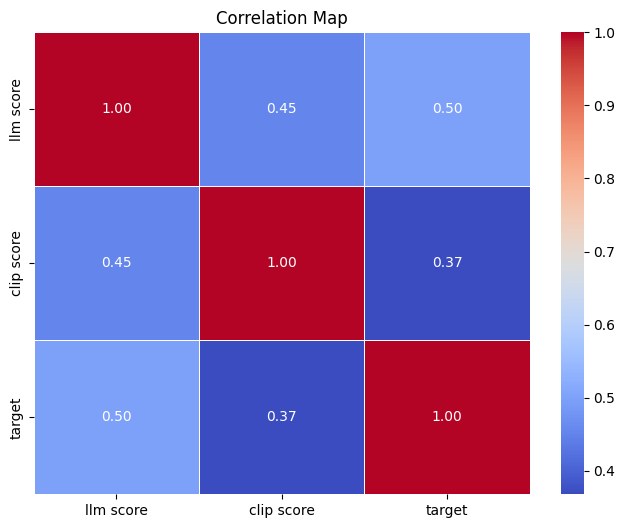

In [161]:
from scipy.stats import pearsonr
import seaborn as sns
import pandas as pd

corr_matrix = df.corr()
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Map')
plt.show()